So here's what I have in mind to begin with. It's pretty sloppy, but hopefully it'll give you the idea.

You start with a of list daily cases from, say, New York like the one I'm attaching (for simplicity, I included only cases through March 31).

You assume that each case turns into a death with some probability, call it d. In my example d = .1

This p is distributed over days in some way. In my example, it's binomially distributed with p = .8 and N = 10.

So now you can compute how many people die each day based on cases from all previous days. I've done this up through cases on Day 6.

Then to get the total number of deaths for each day, you just sum across the deaths resulting from cases on all the preceding days. I've done this but of course it's mostly incomplete because you can't really do it easily in Excel. But I'm assuming it'd be trivial to do in Python.

So why don't you work on that and then when you have it going we'll work on fitt¬ing the model to the data.

## Imports

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get data

In [2]:
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
df = pd.read_csv(url, index_col="date", parse_dates=True)

In [3]:
nyc = df.query("state == 'New York' & county == 'New York City'")
nyc = nyc.drop('fips', axis=1)

nyc.tail()

,county,state,cases,deaths
date,,,,
2020-07-11,New York City,New York,223382,22750
2020-07-12,New York City,New York,223725,22755
2020-07-13,New York City,New York,223977,22795
2020-07-14,New York City,New York,224293,22808
2020-07-15,New York City,New York,224662,22825


In [85]:
test = nyc.iloc[:50, :].copy()
test.tail()

,county,state,cases,deaths
date,,,,
2020-04-15,New York City,New York,121653,11566
2020-04-16,New York City,New York,126623,12109
2020-04-17,New York City,New York,131003,12283
2020-04-18,New York City,New York,135052,12411
2020-04-19,New York City,New York,138370,13632


In [86]:
# assume a case turns into a death over n days 
# uniformly with some probability d
d = 0.1  # 10% chance of death per case

# predict total deaths for each day
# draw total deaths from a binomial distribution

# d is distributed over days, e.., binomially with p=.8 and N=10

# take a particular day. 

test["cpd"] = test["cases"].diff()  # cases per day
test.loc["2020-03-01", "cpd"] = 1  # deal with NaN

test["dpd_pred"] = np.random.binomial(test["cpd"], d)  # eventual deaths per day ~ Bin(#cases, d)
test["deaths_pred"] = test["dpd_pred"].cumsum()

### What I've done

So far, all I've done is made a cases-per-day column (essentially the derivative of the "cases" column),  
then for however many new cases there are on a given day, I model the number of deaths that will eventually occur as a result of those cases binomially with n=#cases and p=death chance.  
The binomial distribution makes sense since the number of deaths is essentially a sum of Bernoullis, where each bernoulli is just a yes/no of whether a given person will die with probability d.  

The deaths_pred column should theoretically always be slightly higher than the deaths column, because the deaths_pred column is a model of the total number of deaths that will *eventually* happen as a result of the current case count.

In [87]:
test.tail()

,county,state,cases,deaths,cpd,dpd_pred,deaths_pred
date,,,,,,,
2020-04-15,New York City,New York,121653,11566,8021.0,759,12164
2020-04-16,New York City,New York,126623,12109,4970.0,481,12645
2020-04-17,New York City,New York,131003,12283,4380.0,457,13102
2020-04-18,New York City,New York,135052,12411,4049.0,399,13501
2020-04-19,New York City,New York,138370,13632,3318.0,344,13845


## Accounting for delay in death

For each new day of cases, define $X$ as the day at which a particular new case (starting from $X_0$, the initial day) will die, given that they will die at some point.

Theoretically, X will have a small probability mass for the first couple of weeks, and then as the doomed patient's condition worsens, X's mass will increase. There will probably be a large tail probability, so its distribution will have a positive skew.  

I'll begin by modeling X as gamma-distributed, and playing around with the parameters until I get a distribution that looks kind of like what I'm envisioning.

16.0

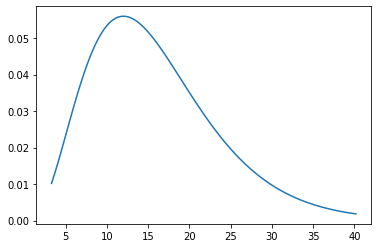

In [119]:
from scipy.stats import gamma

a = 4
X = gamma(a, scale=4)
xaxis = np.linspace(X.ppf(0.01), X.ppf(0.99), 100)

plt.plot(xaxis, X.pdf(xaxis))
X.mean()